# Import Modules
You may need to install some of them.
But if you activate the environment inside this `examples` folder, all dependencies should be included.

In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using Revise, FFTW, DeconvOptim, ImageShow, TestImages, Colors, Noise, Zygote

┌ Info: Precompiling Noise [81d43f40-5267-43b7-ae1c-8b967f377efa]
└ @ Base loading.jl:1423
┌ Warning: Module ImageCore with build ID 343971817478823 is missing from the cache.
│ This may mean ImageCore [a09fc81d-aa75-5fe9-8630-4744c3626534] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing Noise [81d43f40-5267-43b7-ae1c-8b967f377efa].
└ @ Base loading.jl:1124


In [3]:
img = Float32.(testimage("fabio_gray_512"))

┌ Warning: Replacing module `ImageCore`
└ @ Base loading.jl:1036


512×512 Matrix{Float32}:
 0.521569  0.517647  0.505882  0.498039  …  0.184314  0.188235  0.188235
 0.482353  0.478431  0.466667  0.458824     0.184314  0.188235  0.188235
 0.407843  0.403922  0.392157  0.392157     0.184314  0.184314  0.184314
 0.372549  0.368627  0.352941  0.356863     0.184314  0.184314  0.184314
 0.384314  0.376471  0.360784  0.360784     0.180392  0.180392  0.180392
 0.384314  0.376471  0.364706  0.360784  …  0.180392  0.180392  0.180392
 0.372549  0.364706  0.352941  0.352941     0.176471  0.180392  0.180392
 0.368627  0.360784  0.34902   0.34902      0.176471  0.180392  0.180392
 0.368627  0.360784  0.34902   0.34902      0.176471  0.176471  0.176471
 0.372549  0.364706  0.352941  0.352941     0.176471  0.176471  0.176471
 0.376471  0.372549  0.360784  0.356863  …  0.176471  0.176471  0.176471
 0.380392  0.376471  0.368627  0.364706     0.176471  0.176471  0.176471
 0.384314  0.380392  0.372549  0.368627     0.180392  0.180392  0.180392
 ⋮                        


## More complex forward 
Imagine a measurement system which measures the following three images

In [20]:
x = Float32.(range(-1, 1, length=512))
psf = ifftshift(exp.(- (x.^2 .+ x'.^2 / 10) / 0.0005f0))
psf ./= sum(psf)
otf = rfft(psf)

psf2 = ifftshift(exp.(- (x.^2 .+ x'.^2) / 0.001f0))
psf2 ./= sum(psf2) .* 3
otf2 = rfft(psf2)


function forward(img)
    img_1 = irfft(rfft(img) .* otf, 512)
    img_2 = irfft(rfft(img) .* otf2, 512)
    img_3 = irfft(rfft(img) .* otf2 .* 10, 512)

    
    img_1_z = Zygote.@ignore ones(eltype(img), size(img))
    img_2_z = Zygote.@ignore copy(img_1_z)
    img_3_z = Zygote.@ignore zeros(eltype(img), size(img))
    
    Zygote.@ignore img_1_z[1:250, 1:250] .= 0
    Zygote.@ignore img_2_z[150:end, 150:end] .= 0
    Zygote.@ignore img_3_z[150:250, 150:250] .= 1

    return img_1 .* img_1_z, img_2 .* img_2_z, img_3 .* img_3_z
end




loss_single_img = Poisson()

function my_loss(measurement, forward, x)
    return sum(loss_single_img.(measurement, forward))
end

my_loss (generic function with 2 methods)

In [5]:
measurements = forward(img)

(Float32[0.0 0.0 … 0.44208196 0.4459638; 0.0 0.0 … 0.4039207 0.4081468; … ; 0.5259912 0.52898735 … 0.51986676 0.5229427; 0.488483 0.49185687 … 0.4815482 0.48503712], Float32[0.15228832 0.15523809 … 0.14647916 0.14934114; 0.14408621 0.14727227 … 0.13773194 0.14087509; … ; 0.16838425 0.17082441 … 0.0 0.0; 0.16048288 0.16318136 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

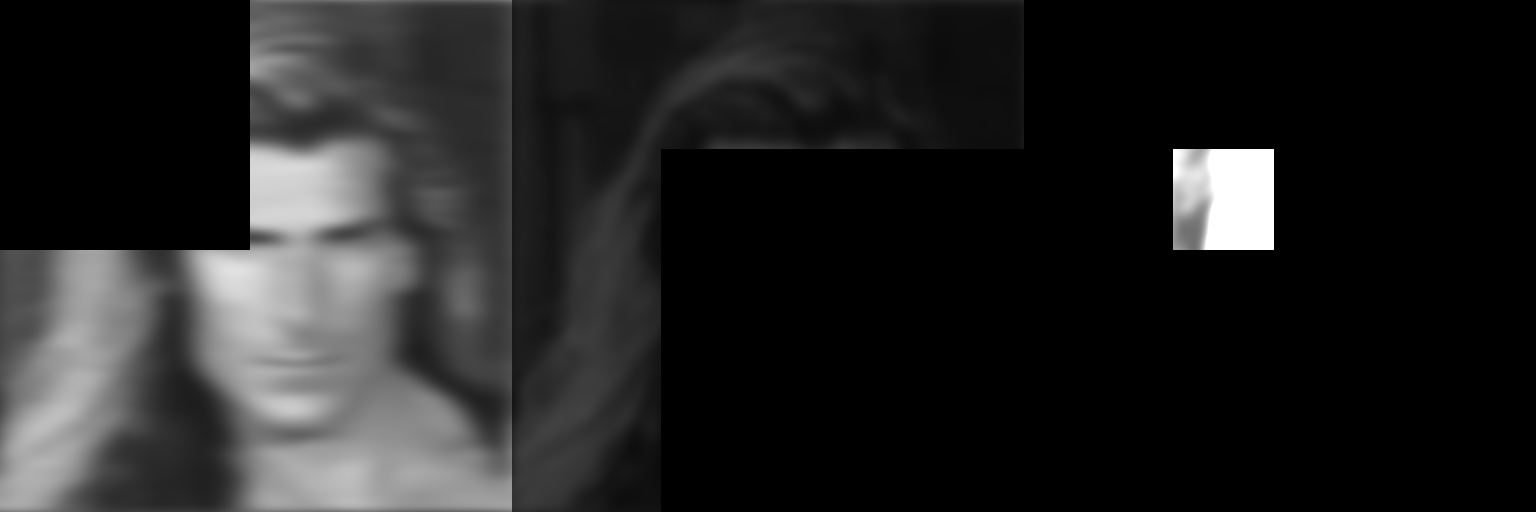

In [6]:
[Gray.(measurements[1]) Gray.(measurements[2]) Gray.(measurements[3])]

## Create initial guess

In [7]:
rec0 = 5f-1 .* ones(eltype(img), size(img));

In [8]:
reg = nothing#TV()

In [31]:
@time res, optim_res = invert(measurements, rec0, forward, loss=my_loss, regularizer=reg, iterations=100)

  2.164946 seconds (174.87 k allocations: 3.894 GiB, 22.16% gc time, 3.71% compilation time)


(Float32[0.4555431 0.47352144 … 0.41998288 0.43742877; 0.38622716 0.40565756 … 0.34826612 0.3668198; … ; 0.6053888 0.6174532 … 0.58123326 0.5931092; 0.53226626 0.5477596 … 0.50132096 0.5165406],  * Status: success

 * Candidate solution
    Final objective value:     2.011029e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.89e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    40
    f(x) calls:    61
    ∇f(x) calls:   40
)

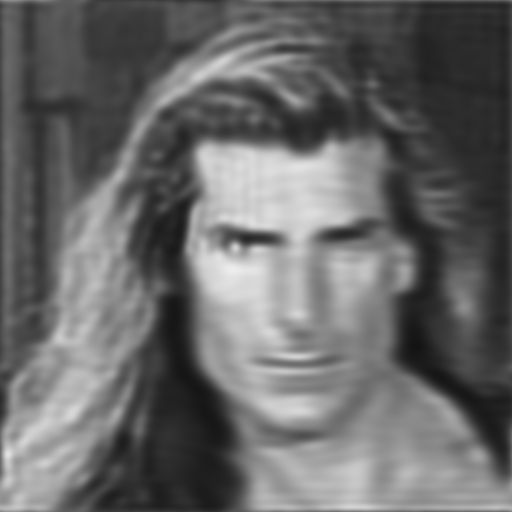

In [32]:
Gray.(res)

## Bringing that to CUDA
We need to ensure that all array are `CuArray`s and then everything works

In [23]:
using CUDA

In [24]:
otf_c = CuArray(otf)
otf2_c = CuArray(otf2)
img_c = CuArray(img)

p = plan_rfft(img_c)
p_inv = inv(p)

function forward_c(img)
    # use plan and p_inv.scale because of a Zygote and CUDA bug
    img_1 = p_inv.scale .* (p_inv.p * ((p * img) .* otf_c))
    img_2 = p_inv.scale .* (p_inv.p * ((p * img) .* otf2_c))
    img_3 = p_inv.scale .* (p_inv.p * ((p * img) .* otf2_c .* 10))

    
    img_1_z = Zygote.@ignore CUDA.ones(eltype(img), size(img))
    img_2_z = Zygote.@ignore copy(img_1_z)
    img_3_z = Zygote.@ignore CUDA.zeros(eltype(img), size(img))
    
    Zygote.@ignore img_1_z[1:250, 1:250] .= 0
    Zygote.@ignore img_2_z[150:end, 150:end] .= 0
    Zygote.@ignore img_3_z[150:250, 150:250] .= 1

    return img_1 .* img_1_z, img_2 .* img_2_z, img_3 .* img_3_z
end

forward_c (generic function with 1 method)

In [25]:
measurements_c = forward_c(CuArray(img))

(Float32[0.0 0.0 … 0.4420819 0.44596368; 0.0 0.0 … 0.40392068 0.40814668; … ; 0.52599114 0.5289873 … 0.5198666 0.5229425; 0.48848298 0.49185684 … 0.48154807 0.48503694], Float32[0.15228832 0.15523806 … 0.1464791 0.14934112; 0.14408618 0.14727226 … 0.1377319 0.14087507; … ; 0.16838422 0.17082438 … 0.0 0.0; 0.16048285 0.16318135 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [26]:
rec0_c = 5f-1 .* CUDA.ones(eltype(img), size(img));

In [30]:
CUDA.@time res, optim_res = invert(measurements_c, rec0_c, forward_c, loss=my_loss, regularizer=reg, iterations=100)

  0.137452 seconds (261.55 k CPU allocations: 16.940 MiB) (6.63 k GPU allocations: 3.553 GiB, 4.47% memmgmt time)


(Float32[0.45538768 0.47314876 … 0.42027557 0.43750313; 0.38637415 0.4055846 … 0.34884626 0.36719266; … ; 0.6046055 0.6165469 … 0.5807384 0.5924696; 0.53175175 0.5470609 … 0.5012087 0.5162295],  * Status: success

 * Candidate solution
    Final objective value:     2.011029e+05

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.98e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    37
    f(x) calls:    57
    ∇f(x) calls:   37
)

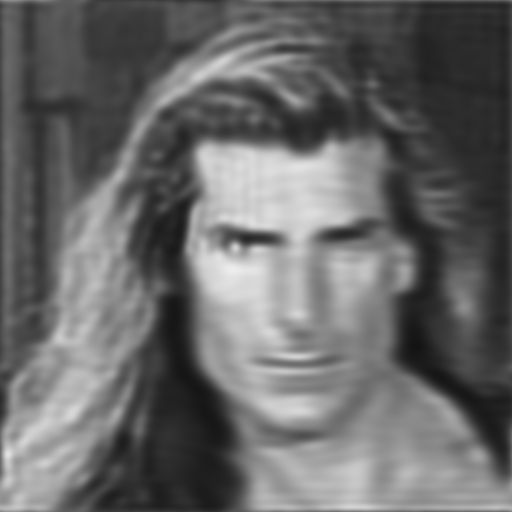

In [28]:
Gray.(Array(res))